In [0]:
 from google.colab import drive
 drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!pip3 install -q torch torchvision

In [0]:
!pip3 install -q Pillow

In [0]:
import os

In [0]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

In [0]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [0]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    
    # raise Exception("Not implemented")
    accuracy = 0
    steps = 0
    for i_step, (x, y,_) in enumerate(loader):

        x_gpu = x.to(device)
        y_gpu = y.to(device)

        prediction = torch.argmax(model(x_gpu), dim=1)
        
        for i in range(len(y_gpu)):
            if prediction[i] == y_gpu[i]:
                accuracy += 1
            
            steps += 1
            
    accuracy = accuracy/(steps)
        
    return accuracy

In [0]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2020-05-19 11:00:34--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  37.2MB/s    in 15s     

2020-05-19 11:00:49 (36.3 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2020-05-19 11:00:58--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[====

In [0]:
path_train = '/content/train_kaggle/'
path_test = '/content/test_kaggle/'

In [0]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.files = [f for f in os.listdir(self.folder) if os.path.isfile(os.path.join(self.folder, f))]
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        # create reading image file
        if torch.is_tensor(index):
            index = index.tolist()

        img_name = os.path.join(self.folder + self.files[index])
        
        img = Image.open(img_name)

        if self.transform:
            img = self.transform(img)

        prefix = self.files[index].split('_')[0]
        if prefix in ['frankfurter', 'chili-dog', 'hotdog']:
            y = 1
        else:
            y = 0

        img_id = self.files[index]
        return img, y, img_id

In [0]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [0]:
import torch.nn as nn
import torch.optim as optim

In [0]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
# TODO: Freeze all the layers of this model and add a new output layer

for param in model.parameters():
    param.requires_grad = False

In [0]:
model.type(torch.cuda.FloatTensor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
num_ftrs = model.fc.in_features

In [0]:
model.fc = nn.Linear(num_ftrs, 2)

In [0]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
dataset = HotdogOrNotDataset(train_folder)

In [0]:
batch_size = 64

In [0]:
data_size = len(dataset)

In [0]:
validation_fraction = .2

In [0]:
val_split = int(np.floor((validation_fraction) * data_size))

In [0]:
indices = list(range(data_size))

In [0]:
np.random.seed(42)

In [0]:
np.random.shuffle(indices)

In [0]:
val_indices, train_indices = indices[:val_split], indices[val_split:]

In [0]:
train_sampler = SubsetRandomSampler(train_indices)

In [0]:
val_sampler = SubsetRandomSampler(val_indices)

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

In [0]:
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

In [0]:
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последгний слой на новый и обучать всю модель целиком.

In [0]:
import torch.nn as nn
import torch.optim as optim

In [0]:
model = models.resnet18(pretrained=True)

In [0]:
# TODO: Add a new output layer and train the whole model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [0]:
import torch.nn as nn
import torch.optim as optim

In [0]:
model = models.resnet18(pretrained=True)

In [0]:
for param in model.parameters():
    param.requires_grad = True

In [0]:
# TODO: Add a new output layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# Hint - look into what PyTorch optimizers let you configure!

optimizer = optim.SGD([
                {'params': model.conv1.parameters(), 'lr': 0.0001},
                {'params': model.layer1.parameters(), 'lr': 0.0001},
                {'params': model.layer2.parameters(), 'lr': 0.0001},
                {'params': model.layer3.parameters(), 'lr': 0.0001},
                {'params': model.layer4.parameters(), 'lr': 0.0001},
                {'params': model.fc.parameters(), 'lr': 0.001}
            ], momentum=0.9)

In [0]:
# loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [0]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [0]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    """
    predictions = []
    ground_truth = []
    
    model.eval() # Evaluation mode

    for i in indices:
        x, y, _ = train_dataset[i]

        x = x.unsqueeze(0)

        x_gpu = x.to(device)

        predictions.append((torch.argmax(model(x_gpu), dim = 1)).cpu().data.numpy()[0])
        ground_truth.append(y)
    
    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

И теперь можно визуализировать false positives и false negatives.

In [0]:
orig_dataset = HotdogOrNotDataset(path_train)

In [0]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

In [0]:
def false_positive_calc(predictions, gt, indices):
    fp_idx = []
    for i in range(len(predictions)):
        if (predictions[i] == 1) & (gt[i] == 0):
           fp_idx.append(indices[i])
    return fp_idx

In [0]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = false_positive_calc(predictions, gt, val_indices)

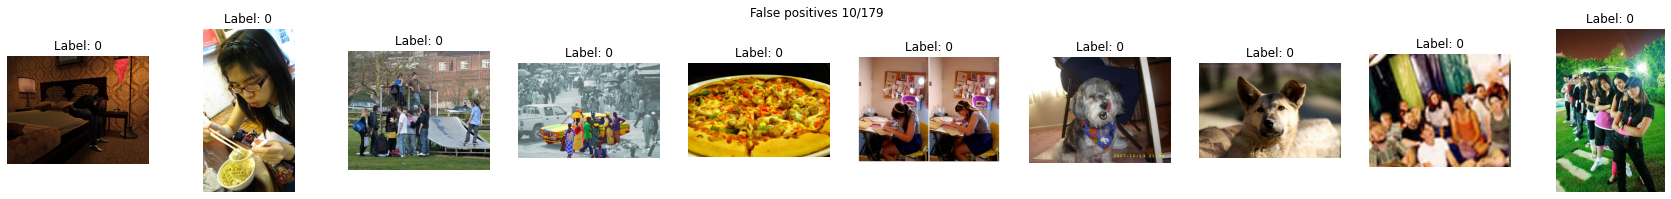

In [0]:
visualize_samples(orig_dataset, false_positive_indices, "False positives")

In [0]:
# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
def false_negatives_calc(predictions, gt, indices):
    fn_idx = []
    for i in range(len(predictions)):
        if (predictions[i] == 0) & (gt[i] == 1):
           fn_idx.append(indices[i])
    return fn_idx

false_negatives_indices = false_negatives_calc(predictions, gt, val_indices)

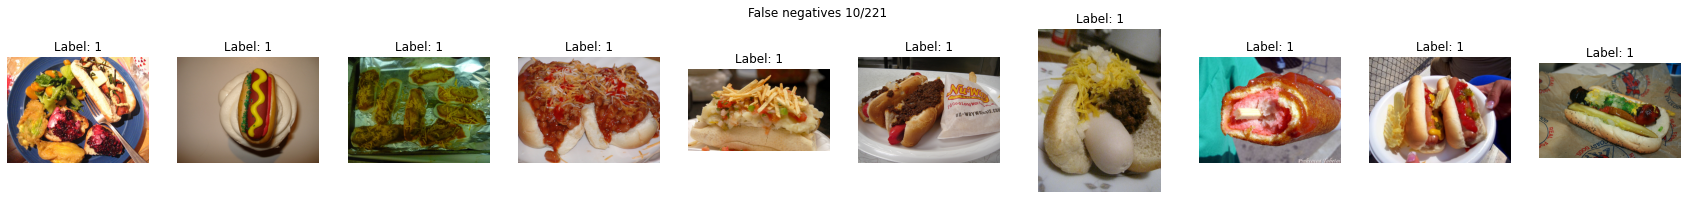

In [0]:
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

In [0]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, gt):
    fn = 0
    fp = 0
    tp = 0
    tn = 0
    for i in range(len(predictions)):
        # FN
        if (predictions[i] == 0) & (gt[i] == 1):
            fn += 1
        # FP
        elif (predictions[i] == 1) & (gt[i] == 0):
            fp += 1
        # TP
        elif (predictions[i] == 1) & (gt[i] == 1):
            tp += 1
        # TN
        else:
            tn +=1

    precision = tp / (tp + fp)

    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)

    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.262, P: 0.284, R: 0.243


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [0]:
# 1. augmentation

In [0]:
# 2. перебор гиперпараметров

In [0]:
# 3. различные оптимизаторы

In [0]:
# 4. какие слои тюнить: разный lr на разные слои

In [0]:
# 5. learning rate annealing: пилообразное изменение lr по эпохам

In [0]:
# 6. на какой эпохе останавливаться: уйти от переобучения, сохранять модели

In [0]:
# TODO: Train your best model!
best_model = None

In [0]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model

## Визуализируйте ошибки лучшей модели

In [0]:
# TODO Visualize false positives and false negatives of the best model on the validation set

In [0]:
def create_test_loader(folder, batch_size = 64):
    test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
    
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    return test_loader

test_loader = create_test_loader(test_folder)